In [26]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

!pip install tqdm
from tqdm import tqdm

### Correlation map

<Axes: >

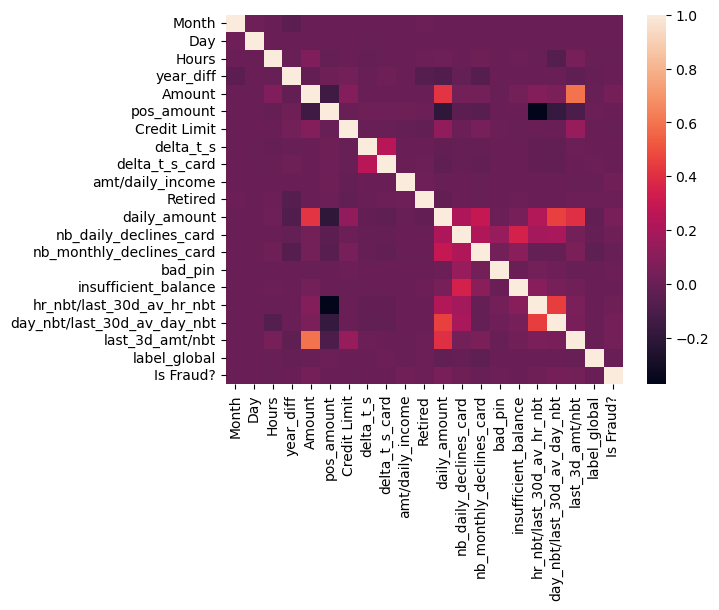

In [11]:
sns.heatmap(df_cct[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?']].corr())

In [12]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'pos_amount'],
      dtype='object')

### Preprocessing (code to create standarized (by User) dataset) - DO NOT RUN

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_cct.loc[:,~df_cct.columns.isin(["User","Card", 'pos_amount',"label_global","Retired", "bad_pin", "insufficient_balance","Is Fraud?"])].select_dtypes(include=numerics).columns.to_list()
cat = df_cct.select_dtypes(include=['object']).columns.to_list()


In [15]:
from sklearn.preprocessing import RobustScaler
!pip install tqdm
from tqdm import tqdm
scaler = RobustScaler()
df = pd.DataFrame()
for i in tqdm(range(2000)):
    user_i = df_cct[df_cct["User"] == i]
    user_i[num] = scaler.fit_transform(user_i[num])
    df = pd.concat([df,user_i], axis=0)


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_3666/2244991325.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_i[num] = scaler.fit_transform(user_i[num])
/tmp/ipykernel_3666/2244991325.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_i[num] = scaler.fit_transform(user_i[num])
  0%|          | 2/2000 [00:00<02:03, 16.12it/s]/tmp/ipykernel_3666/2244991325.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [16]:
df.to_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Encode categorical variables

In [5]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")

In [6]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [7]:
# Pour "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [8]:
# Pour "Card Type"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [9]:
# Pour "label global"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["label_global"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [10]:
df_cct.rename(columns={0:"0", -1: "-1", 1:"1", 2:"2", 3: "3", 4:"4", 5:"5", 6:"6"}, inplace=True)

In [11]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'pos_amount', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)', '-1', '0', '1', '2', '3', '4', '5', '6'],
      dtype='object')

### Create train/val/test datasets

In [12]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"Is Fraud?",
        "-1","0","1","2","3","4","5","6"]
df_selec = df_cct[features] # 21 features + clusters
X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]
y = df_selec["Is Fraud?"]

In [14]:
## Splitting the data into train and test data  (70:30)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle = True, random_state = 0, stratify = y)


In [15]:
df_train = df_selec.loc[X_train.index]

In [16]:
## Checking class distribution in stratified train-test split
from collections import Counter

print("In y dataset:", Counter(y))
print("\nIn y_train set:", Counter(y_train))
print("\nIn y_test set:", Counter(y_test))

In y dataset: Counter({0: 24357143, 1: 29757})

In y_train set: Counter({0: 17050000, 1: 20830})

In y_test set: Counter({0: 7307143, 1: 8927})


## Model Building perso

In [17]:
#Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'Precision','Recall','F1 score', "Our Score"])

In [19]:
# opening raw cct file
cct_init = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

#building our own score
def our_score(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = cct_init.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["Amount"]>=15].index

    df_tp = cct_init.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["Amount"]>=15].index

    df_fn = cct_init.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["Amount"]>=15].index

    our_score = -15*(len(fp_new) + len(tp_new)) + cct_init.loc[tp_new].Amount.sum() - cct_init.loc[fn_rows].Amount.sum() - cct_init.loc[tp_rows].Amount.sum()

    our_score_norm = (our_score + cct_init.loc[fn_rows].Amount.sum() + cct_init.loc[tp_rows].Amount.sum())/(cct_init.loc[tp_new].Amount.sum()+cct_init.loc[fn_new].Amount.sum() - 15*(len(tp_new)+len(fn_new)))

    return our_score_norm

In [20]:
# plot confusion matrix
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)


def print_model_metrics(y_test,y_pred):
    print(" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cp)
    plt.show()


In [21]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()


## Decision Tree

### Train set : 70% dataset, integrating label global variable

In [22]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
kf.split(X_train, y_train)
for train_index, test_index in kf.split(X_train, y_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape , str("\n"))
    print("TRAIN:", train_index, "\n\nTEST:", test_index , str("\n"))

TRAIN: (11380553,) TEST: (5690277,) 

TRAIN: [ 5690194  5690195  5690196 ... 17070827 17070828 17070829] 

TEST: [      0       1       2 ... 5747070 5748093 5749391] 

TRAIN: (11380553,) TEST: (5690277,) 

TRAIN: [       0        1        2 ... 17070827 17070828 17070829] 

TEST: [ 5690194  5690195  5690196 ... 11380616 11380617 11380618] 

TRAIN: (11380554,) TEST: (5690276,) 

TRAIN: [       0        1        2 ... 11380616 11380617 11380618] 

TEST: [11335244 11335824 11335932 ... 17070827 17070828 17070829] 



In [35]:
dt_weight1 = pd.DataFrame(columns = ["class_weight_fraud", "f1_score_cv", "our_score_cv"])

cw_range = [1,50,100, 250, 500,1000]
for i in tqdm(cw_range):
    clf = DecisionTreeClassifier(random_state=0, class_weight={1: i, 0: 1})
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_weight1.loc[len(dt_weight1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    


100%|██████████| 5/5 [58:55<00:00, 707.05s/it]


In [41]:
clf = DecisionTreeClassifier(random_state=0, class_weight="balanced")
scores = cross_validate(clf, X_train, y_train, cv = kf, 
scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
n_jobs = -1)
our_score_cv = scores["test_our_score_cv"]
f1_score_cv = scores["test_f1"]
dt_weight1.loc[len(dt_weight1)] = ["balanced", f1_score_cv.mean(), our_score_cv.mean()]

In [42]:
dt_weight1

,class_weight_fraud,f1_score_cv,our_score_cv
0,0.5,0.141844,0.118768
1,0.6,0.142314,0.107778
2,0.7,0.140935,0.111856
3,0.8,0.139469,0.096527
4,0.9,0.137516,0.085948
5,balanced,0.117217,0.050418


Text(0, 0.5, 'Metric Scores')

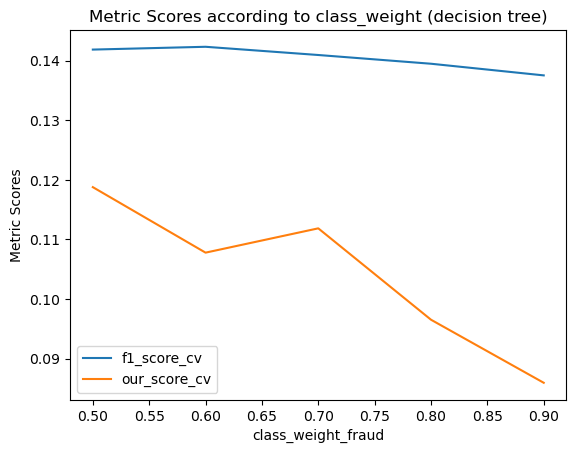

In [37]:

sns.lineplot(dt_weight1, x= "class_weight_fraud", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(dt_weight1, x= "class_weight_fraud", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to class_weight (decision tree)")
plt.ylabel("Metric Scores")


In [ ]:
dt_min_samples_leaf1 = pd.DataFrame(columns = ["min_samples_leaf", "f1_score_cv", "our_score_cv"])
min_sample_leaf_range = [1, 5, 10, 15, 25, 50, 100, 200]
for i in tqdm(min_sample_leaf_range):
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.85, 0:0.15}, min_samples_leaf = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_min_samples_leaf1.loc[len(dt_min_samples_leaf1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    

100%|██████████| 8/8 [1:32:24<00:00, 693.11s/it]


In [ ]:
dt_min_samples_leaf1

,min_samples_leaf,f1_score_cv,our_score_cv
0,1.0,0.141844,0.118768
1,5.0,0.169206,0.150339
2,8.0,0.163973,0.148201
3,10.0,0.159186,0.145356
4,20.0,0.136780,0.125967
5,50.0,0.106356,0.100347
6,100.0,0.080632,0.076962
7,200.0,0.075131,0.057361


Text(0, 0.5, 'Metric Scores')

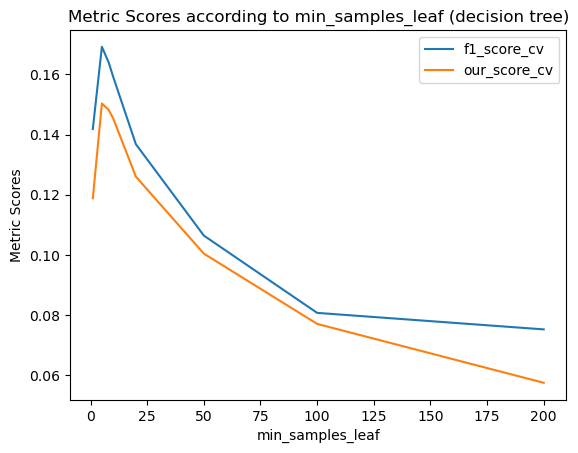

In [ ]:
sns.lineplot(dt_min_samples_leaf1, x= "min_samples_leaf", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(dt_min_samples_leaf1, x= "min_samples_leaf", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to min_samples_leaf (decision tree)")
plt.ylabel("Metric Scores")

In [ ]:
dt_max_depth1 = pd.DataFrame(columns = ["max_depth", "f1_score_cv", "our_score_cv"])
max_depth_range = [i for i in range (1,30,3)]
for i in tqdm(max_depth_range):
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.85, 0:0.15}, 
    min_samples_leaf = int(dt_min_samples_leaf1.loc[dt_min_samples_leaf1["our_score_cv"].idxmax(),  "min_samples_leaf"]), 
    max_depth = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_max_depth1.loc[len(dt_max_depth1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    

 40%|████      | 4/10 [12:32<22:03, 220.54s/it]/opt/mamba/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 10/10 [1:06:41<00:00, 400.19s/it]


In [ ]:
dt_max_depth1

,max_depth,f1_score_cv,our_score_cv
0,1.0,0.000000,0.000000
1,4.0,0.000096,0.000626
2,7.0,0.069700,0.067707
3,10.0,0.119284,0.113985
4,13.0,0.143621,0.126916
5,16.0,0.162997,0.145846
6,19.0,0.169661,0.149065
7,22.0,0.170898,0.149904
8,25.0,0.171103,0.149863
9,28.0,0.170105,0.151188


Text(0, 0.5, 'Metric Scores')

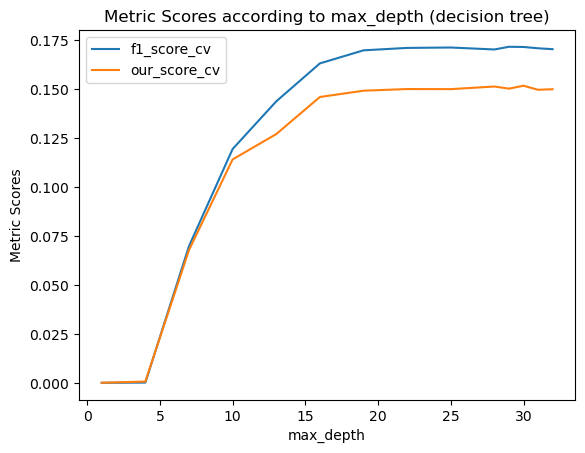

In [ ]:
sns.lineplot(dt_max_depth1, x= "max_depth", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(dt_max_depth1, x= "max_depth", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to max_depth (decision tree)")
plt.ylabel("Metric Scores")

In [ ]:
dt_max_features1 = pd.DataFrame(columns = ["max_features", "f1_score_cv", "our_score_cv"])

max_features_range = ["auto", "sqrt", "log2", None]
for i in tqdm(max_features_range): 
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.85, 0:0.15}, 
    min_samples_leaf = int(dt_min_samples_leaf1.loc[dt_min_samples_leaf1["our_score_cv"].idxmax(),  "min_samples_leaf"]), 
    max_depth = int(dt_max_depth1.loc[dt_max_depth1["our_score_cv"].idxmax(),  "max_depth"]), 
    max_features = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_max_features1.loc[len(dt_max_features1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
dt_max_features1

  0%|          | 0/4 [00:00<?, ?it/s]/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
100%|██████████| 4/4 [19:09<00:00, 287.30s/it]


,max_features,f1_score_cv,our_score_cv
0,auto,0.129696,0.118722
1,sqrt,0.129696,0.118722
2,log2,0.120610,0.099481
3,NaN,0.171372,0.151595


In [50]:
dt_criterion1 = pd.DataFrame(columns = ["criterion", "f1_score_cv", "our_score_cv"])

criterion_range = ["gini", "entropy"]
for i in tqdm(criterion_range): 
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.85, 0:0.15}, 
    min_samples_leaf = int(dt_min_samples_leaf1.loc[dt_min_samples_leaf1["our_score_cv"].idxmax(),  "min_samples_leaf"]), 
    max_depth = int(dt_max_depth1.loc[dt_max_depth1["our_score_cv"].idxmax(),  "max_depth"]), 
    max_features = dt_max_features1.loc[dt_max_features1["our_score_cv"].idxmax(), "max_features"],
    criterion = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_criterion1.loc[len(dt_criterion1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
dt_criterion1

100%|██████████| 2/2 [20:15<00:00, 607.96s/it]


,criterion,f1_score_cv,our_score_cv
0,gini,0.171372,0.151595
1,entropy,0.164632,0.138835


### Trying GridSearchCV

In [ ]:
# Define the parameter sets to test
from sklearn.model_selection import GridSearchCV
param_grid = {
    "class_weight" : [{1: i/100, 0: 1 - i/100} for i in [50,70,90]],
    "min_samples_leaf" : [10, 50, 100],
    'max_depth': [10, 20, 30], 
}

# Define the model to use
model = DecisionTreeClassifier(random_state=0)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=our_score, n_jobs=-1, verbose=10)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_
CV_model.cv_results_

### Results on test set

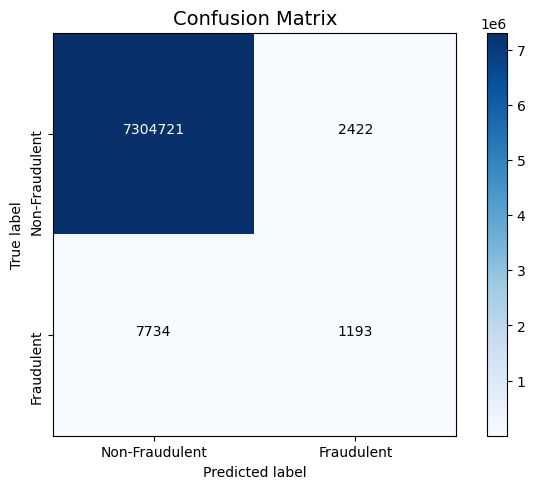

In [63]:
clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.5, 0:0.5}, min_samples_leaf = 5, max_depth = 30, criterion = "gini")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

### Cluster Sampling / Undersampling / Oversampling  /SMOTEK

## Weighted Random Forest

### 70% train set: label global new variable

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_weight1 = pd.DataFrame(columns = ["class_weight_fraud", "f1_score_cv", "our_score_cv"])

cw_range = [1, 50, 100, 250, 500, 1000]
for i in tqdm(cw_range):
    rf = RandomForestClassifier(random_state=0, class_weight={1: i, 0: 1}, n_jobs = -1)
    scores = cross_validate(rf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    rf_weight1.loc[len(rf_weight1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    print(f1_score_cv.mean(), our_score_cv.mean())

 17%|█▋        | 1/6 [17:54<1:29:34, 1074.88s/it]

0.10599943689205331 0.09781292742148358


 33%|███▎      | 2/6 [33:44<1:06:44, 1001.11s/it]

0.07072631822761058 0.05549732449259328


 50%|█████     | 3/6 [48:52<47:56, 958.86s/it]   

0.06829619742535155 0.05519658783825065


 67%|██████▋   | 4/6 [1:02:52<30:23, 911.62s/it]

0.0663954115309643 0.05203868404937135


 83%|████████▎ | 5/6 [1:16:25<14:36, 876.23s/it]

0.06678407321378099 0.053591848879560304


100%|██████████| 6/6 [1:29:50<00:00, 898.38s/it]

0.06624498895364553 0.05528345047055574


In [36]:
rf_minsamplesleaf1 = pd.DataFrame(columns = ["min_samples_leaf", "f1_score_cv", "our_score_cv"])

#unweighted random forest

min_samples_leaf_range = [1,10, 25, 50, 100, 250, 500]
for i in tqdm(min_samples_leaf_range):
    rf = RandomForestClassifier(random_state=0, class_weight={1: 1, 0: 1},
    min_samples_leaf = i, n_jobs = -1)
    scores = cross_validate(rf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    rf_minsamplesleaf1.loc[len(rf_minsamplesleaf1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    print(f1_score_cv.mean(), our_score_cv.mean())

 14%|█▍        | 1/7 [16:19<1:37:58, 979.70s/it]

0.10599943689205331 0.09781292742148358


 29%|██▊       | 2/7 [32:37<1:21:32, 978.50s/it]

0.06165805467428309 0.06112376262038538


 43%|████▎     | 3/7 [48:39<1:04:44, 971.21s/it]

0.030564473761872712 0.03472361125522116


 57%|█████▋    | 4/7 [1:04:45<48:27, 969.10s/it]

0.012577197162202942 0.015532799400825406


 71%|███████▏  | 5/7 [1:20:26<31:57, 958.84s/it]

0.0010552940533404196 0.0027366738240326934


 86%|████████▌ | 6/7 [1:35:40<15:43, 943.51s/it]

0.0 0.0


100%|██████████| 7/7 [1:50:32<00:00, 947.47s/it]

0.0 0.0


Text(0, 0.5, 'Metric Scores')

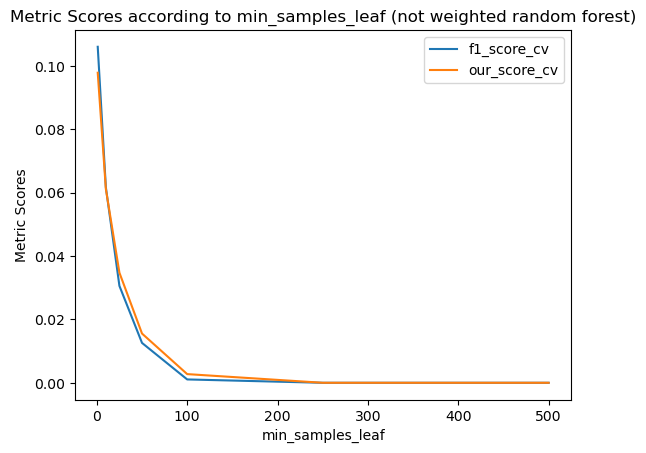

In [42]:
sns.lineplot(rf_minsamplesleaf1, x= "min_samples_leaf", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(rf_minsamplesleaf1, x= "min_samples_leaf", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to min_samples_leaf (not weighted random forest)")
plt.ylabel("Metric Scores")

In [37]:
rff_minsamplesleaf1 = pd.DataFrame(columns = ["min_samples_leaf", "f1_score_cv", "our_score_cv"])

min_samples_leaf_range = [1,10, 25, 50, 100, 250, 500]
for i in tqdm(min_samples_leaf_range):
    rf = RandomForestClassifier(random_state=0, class_weight="balanced_subsample",
    min_samples_leaf = i, n_jobs = -1)
    scores = cross_validate(rf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    rff_minsamplesleaf1.loc[len(rff_minsamplesleaf1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    print(f1_score_cv.mean(), our_score_cv.mean())

 14%|█▍        | 1/7 [14:30<1:27:00, 870.07s/it]

0.06673497049953686 0.05478692382037176


 29%|██▊       | 2/7 [28:48<1:11:54, 862.98s/it]

0.2615710212534179 0.2754437683181414


 43%|████▎     | 3/7 [43:00<57:12, 858.21s/it]  

0.22203462458029133 0.28121278195777094


 57%|█████▋    | 4/7 [57:14<42:49, 856.37s/it]

0.16253361089013038 0.13165111980017988


 71%|███████▏  | 5/7 [1:11:33<28:34, 857.43s/it]

0.11143437315953546 -0.21065155321014337


 86%|████████▌ | 6/7 [1:25:37<14:12, 852.89s/it]

0.06447577993342285 -1.1665951068390243


100%|██████████| 7/7 [1:39:26<00:00, 852.31s/it]

0.04229602734954019 -2.5101180489324926


Text(0, 0.5, 'Metric Scores')

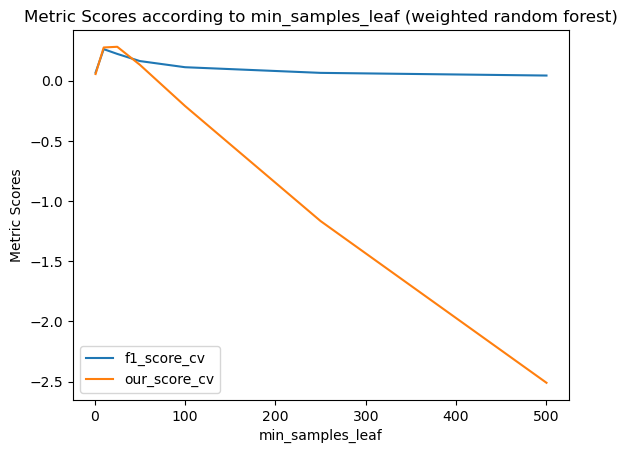

In [41]:
sns.lineplot(rff_minsamplesleaf1, x= "min_samples_leaf", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(rff_minsamplesleaf1, x= "min_samples_leaf", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to min_samples_leaf (weighted random forest)")
plt.ylabel("Metric Scores")

In [44]:
rf_max_depth1 = pd.DataFrame(columns = ["max_depth", "f1_score_cv", "our_score_cv"])
max_depth_range = [i for i in range (1,30,3)]
for i in tqdm(max_depth_range):
    rf = RandomForestClassifier(random_state=0, class_weight = "balanced_subsample", 
    min_samples_leaf = 20, max_depth = i, n_jobs = -1)
    scores = cross_validate(rf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    rf_max_depth1.loc[len(rf_max_depth1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    print(f1_score_cv.mean(), our_score_cv.mean())

 10%|█         | 1/10 [05:16<47:24, 316.05s/it]

0.01101042513510485 -13.867179816505947


 20%|██        | 2/10 [12:15<50:14, 376.83s/it]

0.013634132279284382 -11.960150811809328


 30%|███       | 3/10 [19:48<48:02, 411.85s/it]

0.01637745709567383 -9.539618602608257


 40%|████      | 4/10 [29:34<48:03, 480.60s/it]

0.021473457570032484 -6.657549202664295


 50%|█████     | 5/10 [42:15<48:27, 581.55s/it]

0.036601744789395076 -3.034362497629798


 60%|██████    | 6/10 [56:56<45:33, 683.49s/it]

0.0672338174992587 -1.0020267804176493


 70%|███████   | 7/10 [1:12:46<38:31, 770.56s/it]

0.10832901270465967 -0.214117272256345


 80%|████████  | 8/10 [1:27:41<26:59, 809.98s/it]

0.15224111693262396 0.09444765705700124


 90%|█████████ | 9/10 [1:44:25<14:30, 870.89s/it]

0.19270948078922065 0.22589089307023244


100%|██████████| 10/10 [1:59:02<00:00, 714.20s/it]

0.21816975730506386 0.27215352137097865


Text(0, 0.5, 'Metric Scores')

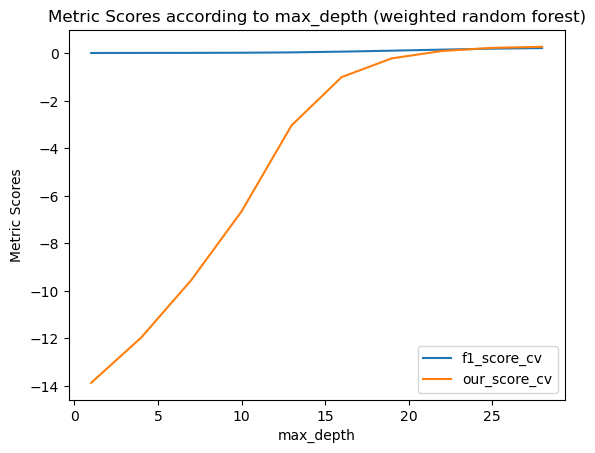

In [45]:
sns.lineplot(rf_max_depth1, x= "max_depth", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(rf_max_depth1, x= "max_depth", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to max_depth (weighted random forest)")
plt.ylabel("Metric Scores")

In [46]:
rf_max_features1 = pd.DataFrame(columns = ["max_features", "f1_score_cv", "our_score_cv"])
max_features_range = ["auto", "sqrt", "log2", None]
for i in tqdm(max_features_range):
    rf = RandomForestClassifier(random_state=0, class_weight = "balanced_subsample", 
    min_samples_leaf = 20, max_depth = int(rf_max_depth1.loc[rf_max_depth1["our_score_cv"].idxmax(), "max_depth"]),
    max_features = i, n_jobs = -1)
    scores = cross_validate(rf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    rf_max_features1.loc[len(rf_max_features1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    print(f1_score_cv.mean(), our_score_cv.mean())

  0%|          | 0/4 [00:00<?, ?it/s]/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is

0.21816975730506386 0.27215352137097865


 50%|█████     | 2/4 [29:56<29:52, 896.46s/it]

0.21816975730506386 0.27215352137097865


 75%|███████▌  | 3/4 [43:19<14:13, 853.48s/it]

0.20189525395011665 0.25022108607277244


100%|██████████| 4/4 [1:50:21<00:00, 1655.27s/it]

0.1471623264360795 0.07477347220457727


In [47]:
rf_n_estimators1 = pd.DataFrame(columns = ["n_estimators", "f1_score_cv", "our_score_cv"])
n_estimators_range = [10, 50, 100, 150, 200, 300, 500]
for i in tqdm(n_estimators_range):
    rf = RandomForestClassifier(random_state=0, class_weight = "balanced_subsample", 
    min_samples_leaf = 20, max_depth = int(rf_max_depth1.loc[rf_max_depth1["our_score_cv"].idxmax(), "max_depth"]),
    max_features = rf_max_features1.loc[rf_max_features1["our_score_cv"].idxmax(), "max_features"],
    n_estimators = i , n_jobs = -1)
    scores = cross_validate(rf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    rf_n_estimators1.loc[len(rf_n_estimators1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    print(f1_score_cv.mean(), our_score_cv.mean())

  0%|          | 0/7 [00:00<?, ?it/s]/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is

0.18702819362994064 0.20450879255966115


/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

0.21171993608131592 0.263015319860425


/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

0.21816975730506386 0.27215352137097865


/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

0.2185477503052694 0.27133983965632447


/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

0.21979057269503968 0.27572813342546904


/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

0.22149197922078104 0.2794700675103441


/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

In [ ]:
sns.lineplot(rf_n_estimators1, x= "n_estimators", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(rf_n_estimators1, x= "n_estimators", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to n_estimators (weighted random forest)")
plt.ylabel("Metric Scores")

In [ ]:
rf_opt = RandomForestClassifier(class_weight = "balanced_subsample",
    min_samples_leaf=200, max_depth=8, n_estimators = 800, n_jobs = -1, random_state= 0)
rf_opt.fit(X_train, y_train)
y_pred_rf_opt = rf_opt.predict(X_test)
cm_opt = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm_opt)

## Balanced Random Forest Classifier